In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from utility_functions import gen_data_dict, get_data, SquaredHingeLoss

np.random.seed(4)
torch.manual_seed(4)

In [2]:
# number of iteration
n_ites = 100

# batch size in training
train_batch_size = 1

# learning rate in training
lr = 0.001

# getting dataframe of error count
err_fold1_df = pd.read_csv('../1_training_data/errors_fold1_base_10.csv')
err_fold2_df = pd.read_csv('../1_training_data/errors_fold2_base_10.csv')

# getting sequences and labels data
seqs   = gen_data_dict('../0_sequences_labels/signals.gz')
labels = gen_data_dict('../0_sequences_labels/labels.gz')

In [3]:
# Chose features
X = pd.read_csv('../1_training_data/seq_features.csv').iloc[:, 1:8].to_numpy()
feature_input_size = X.shape[1]

# feature engineering
X0 = np.log(X[:, 0]).reshape(-1, 1) 
X1 = X[:, 1].reshape(-1, 1)
X2 = np.log(X[:, 2]).reshape(-1, 1) 
X3 = np.log(X[:, 3]).reshape(-1, 1)
X4 = X[:, 4].reshape(-1, 1)
X5 = np.log(np.log(X[:, 5])).reshape(-1, 1)
X6 = np.log(np.log(X[:, 6])).reshape(-1, 1)

# concate together
X = np.concatenate([X0, X1, X2, X3, X4, X5, X6], axis=1)

# normalize them
mean = np.mean(X, axis=0)
std_dev = np.std(X, axis=0)
X = (X-mean)/std_dev

# convert to torch tensor
features = torch.Tensor(X)

In [4]:
# data (targets)
target_df_1 = pd.read_csv('../1_training_data/target_lambda_fold1_base_10.csv')
target_df_2 = pd.read_csv('../1_training_data/target_lambda_fold2_base_10.csv')

targets_low_1  = torch.Tensor(target_df_1.iloc[:, 1:2].to_numpy())
targets_high_1 = torch.Tensor(target_df_1.iloc[:, 2:3].to_numpy())
targets_low_2  = torch.Tensor(target_df_2.iloc[:, 1:2].to_numpy())
targets_high_2 = torch.Tensor(target_df_2.iloc[:, 2:3].to_numpy())

target_fold1 = torch.cat((targets_low_1, targets_high_1), dim=1)
target_fold2 = torch.cat((targets_low_2, targets_high_2), dim=1)

In [5]:
class DLModel(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size):
        super(DLModel, self).__init__()
        self.input_size    = input_size
        self.hidden_layers = hidden_layers
        self.hidden_size   = hidden_size

        if(self.hidden_layers == 0):
            self.linear_model = nn.Linear(input_size, 1)                                                        # Define linear model
        else:
            self.input_layer = nn.Linear(input_size, hidden_size)                                               # Define input layer
            self.hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers-1)])  # Define hidden layers
            self.output_layer = nn.Linear(hidden_size, 1)                                                       # Define output layer
        
    def forward(self, x):
        if(self.hidden_layers == 0):
            return self.linear_model(x)
        else:
            x = torch.relu(self.input_layer(x))
            for layer in self.hidden:
                x = torch.relu(layer(x))
            x = self.output_layer(x)
            return x

In [6]:
def get_df_stat(ldas, err_df, seqs, labels, test_fold):
    header = ['sequenceID', 'lda', 'total_labels', 'err']
    rows = []
    for i in range(len(seqs)):
        # get total labels
        if(test_fold == 1):
            _, neg_start, _, pos_start, _, _, _, _, _ = get_data(i, seqs, labels)
        else:
            _, _, _, _, _, neg_start, _, pos_start, _ = get_data(i, seqs, labels)
        total_labels = len(neg_start) + len(pos_start)

        # round lambda
        ldas = [round(num*2)/2 for num in ldas]
        ldas = [min(5.0, max(-5.0, num)) for num in ldas]

        # get err
        err = err_df.iloc[i][str(ldas[i])]
        
        # add row to rows
        row = [seqs[i][0], ldas[i],  total_labels, err]
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=header)
    return df

In [7]:
def get_acc(df):
    total_label_fold1 = df['total_labels'].sum()
    err1 = df['err'].sum()
    rate1 = (total_label_fold1 - err1)/total_label_fold1
    return rate1*100

In [8]:
def investigate_model(X, y, n_layer, layer_size, lr, n_ites, err_df, seqs, labels, test_fold):
    model = DLModel(feature_input_size, n_layer, layer_size)
    loss_func = SquaredHingeLoss(margin=1)
    optimizer = optim.Adam(model.parameters(), lr)

    # Create DataLoader
    dataset    = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=train_batch_size, shuffle=True)

    # Training loop
    rates = []
    for _ in range(n_ites):
        for inputs, labelss in dataloader:
            optimizer.zero_grad()
            loss = loss_func(model(inputs), labelss)
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            ldas = model(X).numpy().reshape(-1)
        df = get_df_stat(ldas, err_df, seqs, labels, test_fold)
        rate = get_acc(df)
        rates.append(rate)
    
    return rates

In [9]:
def plot_acc_model(rates_fold1, rates_fold2):
    # Plotting the rates_fold1 and rates_fold2
    plt.plot(range(1, len(rates_fold1) + 1), rates_fold1, marker='o', label='rates_fold1')
    plt.plot(range(1, len(rates_fold2) + 1), rates_fold2, marker='o', label='rates_fold2')

    # Plot horizontal lines and label them
    plt.axhline(y=78.99, color='r', linestyle='--', label='linear acc test fold 1')
    plt.text(0, 78.99, 'linear acc test fold 1', color='r', va='bottom')
    plt.axhline(y=73.27, color='g', linestyle='--', label='linear acc test fold 2')
    plt.text(0, 73.27, 'linear acc test fold 2', color='g', va='bottom')

    # Label axes and title
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy rate')
    plt.title('Accuracy compare')
    plt.legend()  # Show legend
    plt.grid(True)
    plt.show()

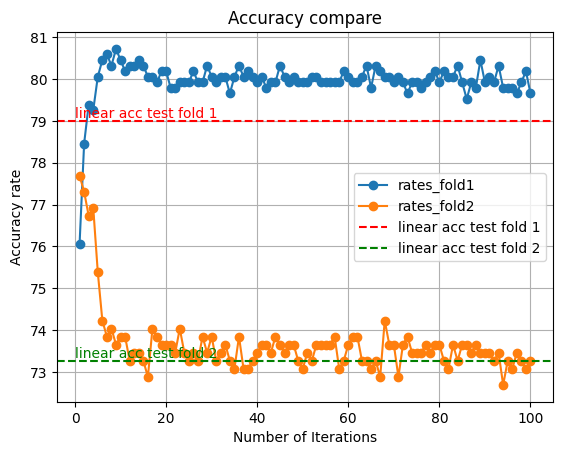

In [10]:
rates_fold1_0_0 = investigate_model(features, target_fold2, 0, 0, lr, n_ites, err_fold1_df, seqs, labels, 1)
rates_fold2_0_0 = investigate_model(features, target_fold1, 0, 0, lr, n_ites, err_fold2_df, seqs, labels, 2)
plot_acc_model(rates_fold1_0_0, rates_fold2_0_0)

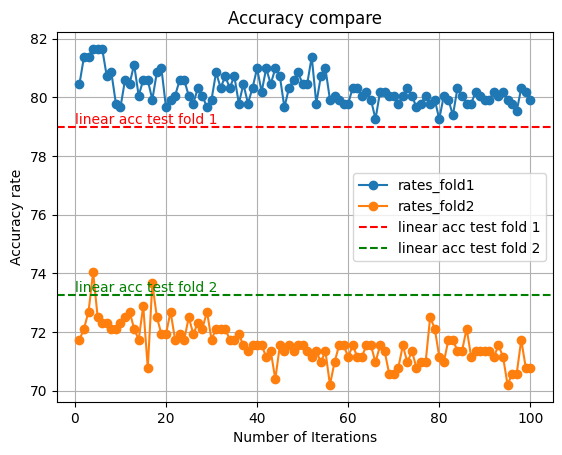

In [11]:
rates_fold1_1_8 = investigate_model(features, target_fold2, 1, 8, lr, n_ites, err_fold1_df, seqs, labels, 1)
rates_fold2_1_8 = investigate_model(features, target_fold1, 1, 8, lr, n_ites, err_fold2_df, seqs, labels, 2)
plot_acc_model(rates_fold1_1_8, rates_fold2_1_8)

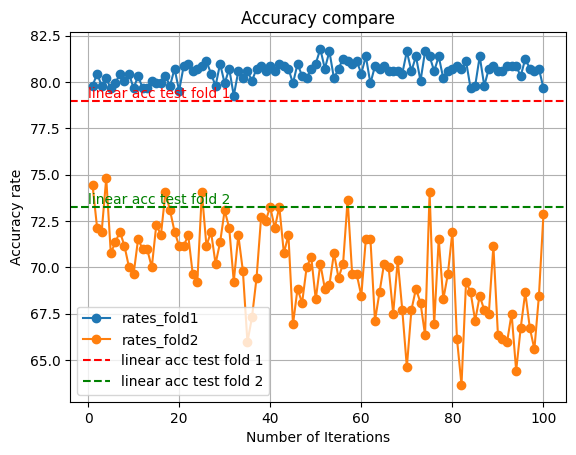

In [12]:
rates_fold1_2_16 = investigate_model(features, target_fold2, 2, 16, lr, n_ites, err_fold1_df, seqs, labels, 1)
rates_fold2_2_16 = investigate_model(features, target_fold1, 2, 16, lr, n_ites, err_fold2_df, seqs, labels, 2)
plot_acc_model(rates_fold1_2_16, rates_fold2_2_16)

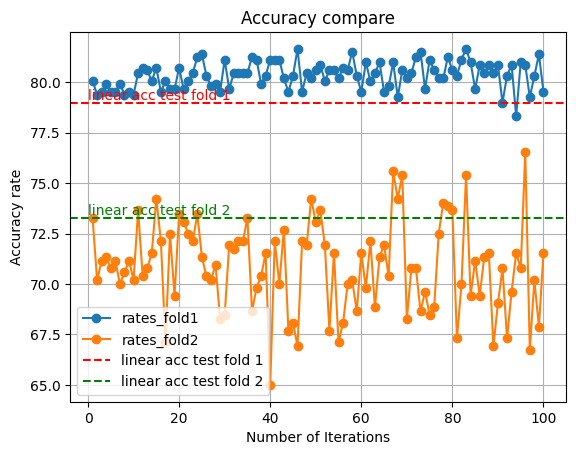

In [13]:
rates_fold1_3_16 = investigate_model(features, target_fold2, 3, 16, lr, n_ites, err_fold1_df, seqs, labels, 1)
rates_fold2_3_16 = investigate_model(features, target_fold1, 3, 16, lr, n_ites, err_fold2_df, seqs, labels, 2)
plot_acc_model(rates_fold1_3_16, rates_fold2_3_16)